# 13/05/2024
## Log-Normal Catalog Generation
$\delta (x)=\frac{\rho (x)- \langle \rho_b \rangle}{\langle \rho \rangle} \quad \langle \delta \rangle =0 \quad \rightarrow \quad \langle \delta (x) \delta (x+r) \rangle = \xi (r)$

$\langle \delta (k) \delta (k_i) \rangle = \delta_D (k+k_i) P(k)$

In [264]:
import numpy as np
import matplotlib.pyplot as plt

import camb
from scipy.interpolate import interp1d

In [265]:
Omega_b=0.05
Omega_c=0.25

h=0.7
As=2.1e-9
ns=0.96

pars=camb.CAMBparams()
pars.set_cosmology(H0=100*h,ombh2=Omega_b*h**2,omch2=Omega_c*h**2)
pars.InitPower.set_params(As=As,ns=ns)

pars.set_matter_power(redshifts=[10.],kmax=10.)
results=camb.get_results(pars)

kh,z,pk=results.get_matter_power_spectrum(minkh=1e-4,maxkh=10,npoints=512)

Text(0.5, 0, '$k [ \\mathrm{Mpc}^{-1}]$')

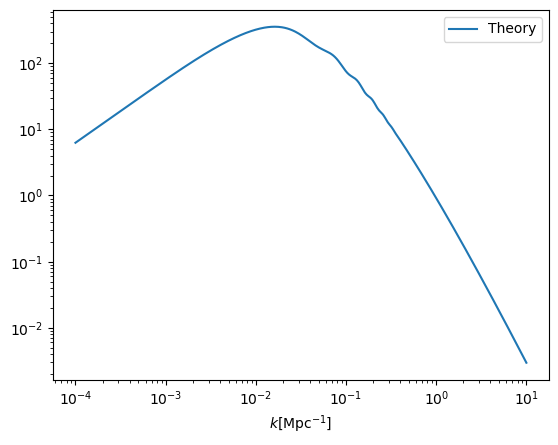

In [266]:
plt.loglog(kh,pk[0],label='Theory')
plt.legend(loc='best')
plt.xlabel(r"$k [ \mathrm{Mpc}^{-1}]$")

In [267]:
pk_interpolate=interp1d(kh,pk[0],kind='cubic',fill_value='extrapolate')

# Create the Grid

In [268]:
side=500
Volume=side**3
n_cells=100
spacing=side/n_cells
print(spacing)

5.0


In [269]:
#h/Mpc
kF=2*np.pi/side
kN=2*np.pi/spacing #resolution

print(kF,kN)
#now I will work in Fourier space

0.012566370614359173 1.2566370614359172


In [270]:
kx=np.fft.fftfreq(n_cells,spacing)*np.pi*2
ky=np.fft.fftfreq(n_cells,spacing)*np.pi*2
kz=np.fft.rfftfreq(n_cells,spacing)*np.pi*2 #la funzione è hermitiana, quindi la trasformata è reale, quindi impongo direttamente che la trasformata in z abbia una dimensione che è la metà rispetto a quella degli altri assi

print(kx.shape,ky.shape,kz.shape)

(100,) (100,) (51,)


In [271]:
#ascending order
kx=np.fft.fftshift(kx)
ky=np.fft.fftshift(ky)

# Generate Gaussian Random Field in Fourier Space

In [272]:
pks=np.zeros((n_cells,n_cells,n_cells//2+1))

for i in range(n_cells):
    kx=i if i<=n_cells // 2 else i-n_cells
    kx*=2*np.pi/side
    for j in range(n_cells):
        ky=j if j<=n_cells//2 else j-n_cells
        ky*=2*np.pi/side
        for k in range(n_cells//2+1):
            kz=k*2*np.pi/side
            knorm=np.sqrt(kx**2+ky**2+kz**2)
            if knorm==0:
                pks[i,j,k]=0
            else:
                pks[i,j,k]=pk_interpolate(knorm)

$\hat \delta (k)=|\delta| exp(i\phi) \quad$ with $\quad 0<\phi<2\pi$

$\delta=N(0,1) \cdot f \quad$ with $\quad f=\sqrt(V\frac{P(k)}{2})$

$\phi$:`phase`

$N(0,1)$:`np.random.normal()`

$\delta$:`delta_k_norm`

In [273]:
phase=np.random.uniform(size=pks.shape)*2*np.pi

delta_k_norm=np.random.normal(size=pks.shape)*np.sqrt(pks*Volume/2)

delta_k=delta_k_norm*(np.cos(phase)+1j*np.sin(phase))

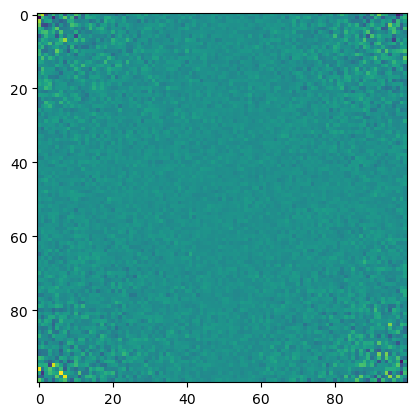

In [274]:
plt.imshow(delta_k_norm[:,:,2])

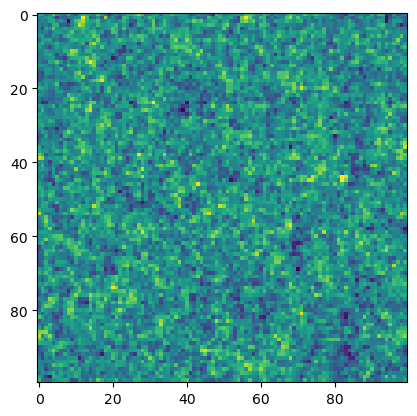

In [275]:
delta_x=np.fft.irfftn(delta_k,norm='backward')/spacing**3

plt.imshow(delta_x[:,:,2])

Text(0.5, 0, '$\\delta(x)$')

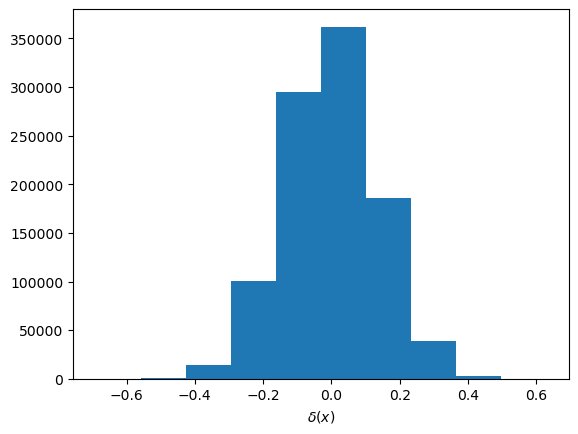

In [276]:
plt.hist(delta_x.flatten())
plt.xlabel(r"$\delta(x)$")

The problem is that Gaussian Fields go below 0

If $\delta$ goes below -1 is a problem

# Extract Power Spectrum

In [277]:
kx=np.fft.fftfreq(n_cells,spacing)*np.pi*2
ky=np.fft.fftfreq(n_cells,spacing)*np.pi*2
kz=np.fft.rfftfreq(n_cells,spacing)*np.pi*2

knorm=[]
for i in range(n_cells):
    kx=i if i<=n_cells // 2 else i-n_cells
    kx*=2*np.pi/side
    for j in range(n_cells):
        ky=j if j<=n_cells//2 else j-n_cells
        ky*=2*np.pi/side
        for k in range(n_cells//2+1):
            kz=k*2*np.pi/side
            knorm.append(np.sqrt(kx**2+ky**2+kz**2))

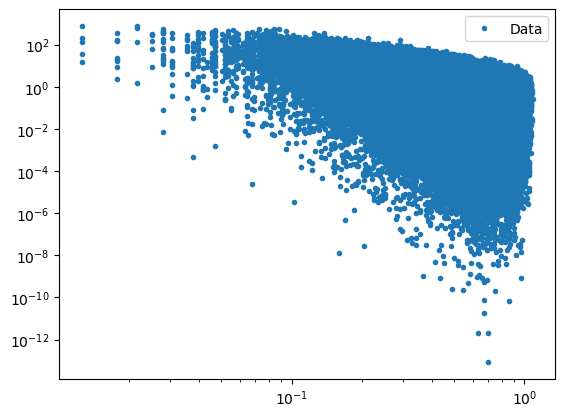

In [278]:
delta_k_sq=np.abs(delta_k)**2

pks=delta_k_sq.flatten()/Volume

plt.loglog(knorm,pks,'.',label='Data')
plt.legend(loc='best')

In [279]:
edges=np.arange(kF,kN,kF)

In [280]:
pk_meas=np.zeros(len(edges)-1)
k_bin=(edges[1:]+edges[0:-1])/2

In [281]:
for i in range(len(k_bin)):
    k_selection=np.where((knorm>=edges[i]) & (knorm<edges[i+1]))
    pk_meas[i]=np.mean(pks[k_selection])

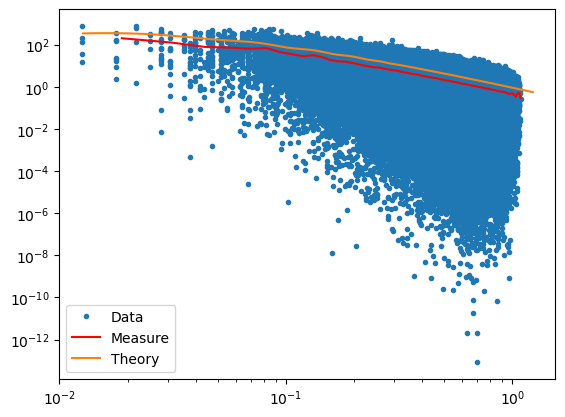

In [282]:
plt.loglog(knorm,pks,'.',label='Data')
plt.loglog(k_bin,pk_meas,'-',label='Measure',color='r')
plt.loglog(kh[(kh>kF)&(kh<kN)],pk[0][(kh>kF)&(kh<kN)],label='Theory')
plt.legend(loc='best')

**Target field**: $\delta(x)=e^{-\sigma_G^2+G(x)}-1$

$\langle G(x)G(x+r) \rangle = \xi_G=ln(1+\xi)$

**Steps**:
1. $P(k)$
2. $P(k)$ on grid
3. $\xi(r)$ on grid
4. $\xi(r) \rightarrow ln(1+\xi)$
5. $P_G(r) \rightarrow fft(ln(1+\xi))$
6. generate of gaussian field
7. apply `log_normal` transformation: $\delta (x)=e^{-\sigma_g^2+G(x)}-1$ ($\sigma_g$ is the variance of $G(x)$)

# Generate LogNormal Density Field

### 1

In [283]:
knorm=np.reshape(knorm,newshape=(100,100,51))

### 2

In [284]:
pks=pk_interpolate(knorm)

### 3

In [285]:
xi=np.fft.irfftn(pks)/spacing**3 #inverse real fast Fourier transform

### 4

In [286]:
xi_g=np.log(1+xi)

### 5

In [296]:
pk_g=np.fft.rfftn(xi_g)*spacing**3

### 6

In [297]:
phase=np.random.uniform(size=pks.shape)*2*np.pi
G_k_norm=np.random.normal(size=pks.shape)*np.sqrt(pk_g*Volume)
G_k_norm[0,0,0]=0
G_k=G_k_norm*(np.cos(phase)+1j*np.sin(phase))

573494969.0751892

In [298]:
#configuration space
G_x=np.fft.irfftn(G_k,norm='backward')/spacing**3

(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        5.0000e+00, 4.0000e+00, 1.2000e+01, 1.0000e+01, 1.5000e+01,
        2.1000e+01, 2.3000e+01, 3.1000e+01, 7.1000e+01, 1.0200e+02,
        1.2700e+02, 1.8000e+02, 2.3700e+02, 3.0600e+02, 4.2200e+02,
        5.7200e+02, 6.7800e+02, 9.3300e+02, 1.1090e+03, 1.4580e+03,
        1.8280e+03, 2.2720e+03, 2.9180e+03, 3.5860e+03, 4.2520e+03,
        5.1630e+03, 6.3620e+03, 7.4410e+03, 8.7460e+03, 1.0336e+04,
        1.2014e+04, 1.3532e+04, 1.5671e+04, 1.7378e+04, 1.9581e+04,
        2.1811e+04, 2.3538e+04, 2.5641e+04, 2.7589e+04, 2.9898e+04,
        3.1800e+04, 3.3302e+04, 3.4864e+04, 3.5757e+04, 3.6801e+04,
        3.6893e+04, 3.7248e+04, 3.7169e+04, 3.6883e+04, 3.6238e+04,
        3.5118e+04, 3.4003e+04, 3.2167e+04, 3.0183e+04, 2.8715e+04,
        2.6538e+04, 2.4569e+04, 2.2425e+04, 2.0342e+04, 1.8189e+04,
        1.6194e+04, 1.4149e+04, 1.2543e+04, 1.0543e+04, 9.0470e+03,
        7.7050e+03, 6.5970e+03, 5.5470e+03, 4.55

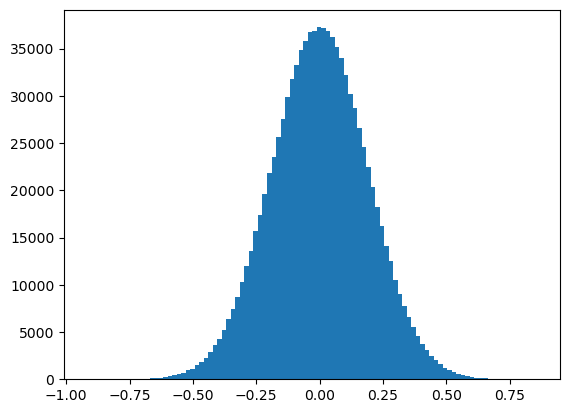

In [299]:
plt.hist(G_x.flatten(),histtype='bar',bins=100,label='G(x)')

### 7

In [300]:
var_G=np.var(G_x)

In [301]:
delta_x=np.exp(G_x-var_G)-1

(array([1.0000e+00, 2.0000e+00, 7.0000e+00, 1.6000e+01, 2.5000e+01,
        4.4000e+01, 1.0200e+02, 2.2900e+02, 4.1700e+02, 7.2800e+02,
        1.2500e+03, 2.0420e+03, 3.2860e+03, 5.1900e+03, 7.8380e+03,
        1.1525e+04, 1.6187e+04, 2.2350e+04, 2.9203e+04, 3.6959e+04,
        4.5349e+04, 5.3230e+04, 6.1698e+04, 6.8166e+04, 7.2558e+04,
        7.4141e+04, 7.4052e+04, 7.1356e+04, 6.6170e+04, 5.8898e+04,
        5.1107e+04, 4.2767e+04, 3.4383e+04, 2.6692e+04, 1.9590e+04,
        1.4302e+04, 1.0098e+04, 6.8310e+03, 4.4980e+03, 2.8550e+03,
        1.6810e+03, 1.0210e+03, 5.2400e+02, 3.1300e+02, 1.7000e+02,
        6.9000e+01, 4.4000e+01, 2.4000e+01, 7.0000e+00, 5.0000e+00]),
 array([-0.91942996, -0.8838286 , -0.84822725, -0.81262589, -0.77702453,
        -0.74142318, -0.70582182, -0.67022047, -0.63461911, -0.59901776,
        -0.5634164 , -0.52781505, -0.49221369, -0.45661233, -0.42101098,
        -0.38540962, -0.34980827, -0.31420691, -0.27860556, -0.2430042 ,
        -0.20740285, -0.17

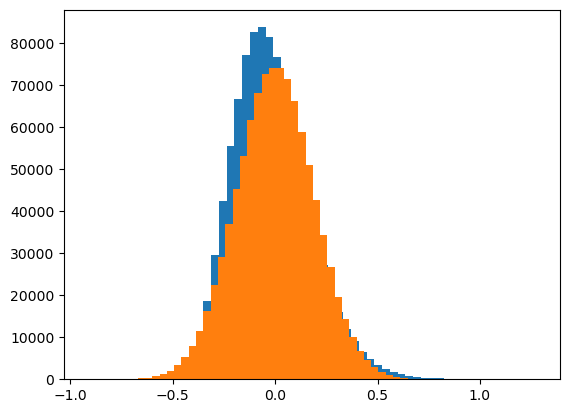

In [302]:
plt.hist(delta_x.flatten(),histtype='bar',bins=50,label='delta(x)')
plt.hist(G_x.flatten(),histtype='bar',bins=50,label='G(x)')

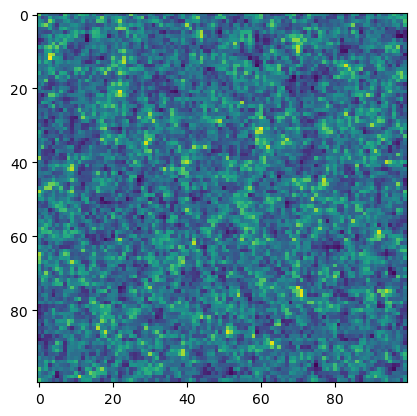

In [303]:
plt.imshow(delta_x[:,:,2])